In [1]:
import seaborn as sns
import metapack as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 

%matplotlib inline
sns.set_context('notebook')


In [2]:
pkg = mp.jupyter.open_package()
#pkg = mp.jupyter.open_source_package()
pkg

In [3]:
hs = pkg.resource('housing').dataframe()
pop = pkg.resource('population').dataframe()

In [4]:
cols = [e.lower() for e in  ['SERIALNO', 'SPORDER', 'PUMA','SEX', 'AGEP', 
                             'RAC1P', 'HISP', 'POVPIP', 'PINCP', 'SCHL']]
weight_cols = [ c for c in pop.columns if c.startswith('pwgtp')]

dfx = pop[cols+weight_cols]

# Recode Race and Ethnicity

```
RAC1P 
Recoded detailed race code 
1  .White alone 
2  .Black or African American alone 
3  .American Indian alone 
4  .Alaska Native alone 
5  .American Indian and Alaska Native tribes specified; or 
   .American Indian or Alaska Native, not specified and no 
   .other races 
6  .Asian alone 
7  .Native Hawaiian and Other Pacific Islander alone 
8  .Some Other Race alone 
9  .Two or More Races 
```

In [5]:
rac1p_map = {
    1: 'white',
    2: 'black',
    3: 'amind',
    4: 'alaskanat',
    5: 'aian',
    6: 'asian',
    7: 'nhopi',
    8: 'other',
    9: 'many'
}
pop['race'] = pop.rac1p.astype('category')
pop['race'] = pop.race.cat.rename_categories(rac1p_map)


# The raceeth variable is the race varaiable, but with 'white' replaced
# with 'hisp' for records that have both is_hsip and white set. So, for 
# raceeth, 'white' means 'non-hispanic white'
pop['is_hisp'] = pop.hisp != 1
pop['raceeth'] = pop['race'].mask(((pop.is_hisp == True) & (pop.race == 'white')), 'hisp')

pop[['rac1p','race','is_hisp','raceeth']].head()

,rac1p,race,is_hisp,raceeth
0,1,white,False,white
1,9,many,False,many
2,8,other,True,other
3,1,white,False,white
4,1,white,False,white


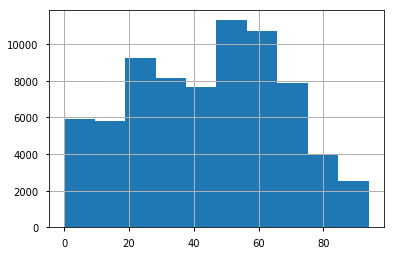

In [6]:
pop[pop.raceeth == 'white'].agep.hist()

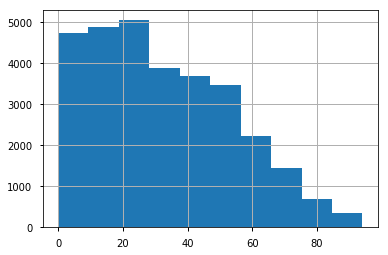

In [7]:
pop[pop.raceeth == 'hisp'].agep.hist()

# Recode Age


Age groups from CHIS:

```
18-25 YEARS    1906
26-29 YEARS     867
30-34 YEARS    1060
35-39 YEARS    1074
40-44 YEARS    1062
45-49 YEARS    1302
50-54 YEARS    1621
55-59 YEARS    1978
60-64 YEARS    2343
65-69 YEARS    2170
70-74 YEARS    1959
75-79 YEARS    1525
80-84 YEARS    1125
85+ YEARS      1161```


In [8]:
ages = ['18-25 YEARS',
 '26-29 YEARS',
 '30-34 YEARS',
 '35-39 YEARS',
 '40-44 YEARS',
 '45-49 YEARS',
 '50-54 YEARS',
 '55-59 YEARS',
 '60-64 YEARS',
 '65-69 YEARS',
 '70-74 YEARS',
 '75-79 YEARS',
 '80-84 YEARS',
 '85+ YEARS']

def extract_age(v):
    if v.startswith('85'):
        return pd.Interval(left=85, right=120, closed='both')
    else:
        l,h,_ = v.replace('-',' ').split()
        return pd.Interval(left=int(l), right=int(h), closed='both')
    
age_ranges = [ (extract_age(v), v) for v in ages]

age_index = pd.IntervalIndex(list(ar[0] for ar in age_ranges))
    
pop['age_group'] = pd.cut(pop.agep,age_index).astype('category')
pop['age_group'].cat.rename_categories(dict(age_ranges), inplace=True)
pop[['agep','age_group']].head()

,agep,age_group
0,93,85+ YEARS
1,36,35-39 YEARS
2,28,26-29 YEARS
3,26,26-29 YEARS
4,30,30-34 YEARS


# Recode Poverty Level

In [9]:
povlvls = ['0-99% FPL', '100-199% FPL', '200-299% FPL', '300% FPL AND ABOVE']
pov_index = pd.IntervalIndex(
    [pd.Interval(left=0, right=99, closed='both'),
    pd.Interval(left=100, right=199, closed='both'),
    pd.Interval(left=200, right=299, closed='both'),
    pd.Interval(left=300, right=501, closed='both')]
)

In [10]:
pop.povpip.describe()

count    139372.000000
mean        321.347509
std         168.395795
min           0.000000
25%         170.000000
50%         339.000000
75%         501.000000
max         501.000000
Name: povpip, dtype: float64

In [11]:
pop['pov_group'] = pd.cut(pop.povpip,pov_index).astype('category')
pop['pov_group'].cat.rename_categories(dict(zip(pov_index, povlvls)), inplace=True)
pop[['povpip','pov_group']].head()

,povpip,pov_group
0,501.0,300% FPL AND ABOVE
1,501.0,300% FPL AND ABOVE
2,0.0,0-99% FPL
3,235.0,200-299% FPL
4,235.0,200-299% FPL


In [12]:
pop.groupby('puma').pwgtp5.sum().sum()

3252098

In [13]:
dfx = pop[cols+['age_group','pov_group','race','is_hisp','raceeth']+weight_cols]
dfx.head(20).T
len(dfx)

145525

# Build the full population set

In [14]:
def build_set(df, rep_no):
    
    new_rows = []
    for row in df.iterrows():
        repl = row[1].at['pwgtp'+str(rep_no)]
        if repl > 1:
            new_rows.extend([row]*(repl-1))
            
    return new_rows


In [15]:
%time new_rows = build_set(dfx, 1)

CPU times: user 13 s, sys: 268 ms, total: 13.2 s
Wall time: 13.4 s


In [16]:
%time t  = dfx.copy().append(new_rows, ignore_index = True)

/Users/eric/proj/virt/data-project/lib/python3.6/site-packages/pandas/core/indexes/api.py:107: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  result = result.union(other)


CPU times: user 2.95 s, sys: 4.43 s, total: 7.38 s
Wall time: 8.28 s


In [17]:
len(t)

3253374

In [18]:
t

,serialno,sporder,puma,sex,agep,rac1p,hisp,povpip,pincp,schl,...,pwgtp73,pwgtp74,pwgtp75,pwgtp76,pwgtp77,pwgtp78,pwgtp79,pwgtp80,0,1
0,2.012000e+12,1.0,7311.0,1.0,93.0,1.0,1.0,501.0,40200.0,18.0,...,17.0,19.0,17.0,14.0,11.0,10.0,15.0,12.0,NaN,NaN
1,2.012000e+12,2.0,7311.0,1.0,36.0,9.0,1.0,501.0,34000.0,19.0,...,18.0,34.0,32.0,17.0,17.0,19.0,23.0,19.0,NaN,NaN
2,2.012000e+12,1.0,7313.0,1.0,28.0,8.0,2.0,0.0,0.0,17.0,...,0.0,3.0,4.0,6.0,0.0,3.0,4.0,7.0,NaN,NaN
3,2.012000e+12,1.0,7306.0,1.0,26.0,1.0,1.0,235.0,24000.0,19.0,...,44.0,15.0,78.0,73.0,43.0,50.0,12.0,40.0,NaN,NaN
4,2.012000e+12,2.0,7306.0,2.0,30.0,1.0,1.0,235.0,19100.0,18.0,...,38.0,12.0,71.0,76.0,43.0,40.0,13.0,42.0,NaN,NaN
5,2.012000e+12,3.0,7306.0,2.0,0.0,1.0,1.0,235.0,NaN,NaN,...,45.0,13.0,79.0,79.0,44.0,41.0,14.0,56.0,NaN,NaN
6,2.012000e+12,1.0,7315.0,2.0,20.0,1.0,1.0,NaN,0.0,19.0,...,27.0,16.0,3.0,15.0,28.0,15.0,16.0,3.0,NaN,NaN
7,2.012000e+12,1.0,7313.0,1.0,47.0,1.0,1.0,501.0,117000.0,22.0,...,4.0,15.0,24.0,4.0,4.0,13.0,13.0,15.0,NaN,NaN
8,2.012000e+12,2.0,7313.0,1.0,21.0,9.0,1.0,501.0,2800.0,19.0,...,4.0,19.0,21.0,5.0,4.0,13.0,12.0,12.0,NaN,NaN
9,2.012000e+12,3.0,7313.0,1.0,73.0,1.0,1.0,501.0,10200.0,10.0,...,6.0,21.0,36.0,6.0,6.0,21.0,20.0,21.0,NaN,NaN


In [19]:
from publicdata import  parse_app_url

url = parse_app_url('census://2015/5/CA/140/B17001')
dfc = url.geoframe()

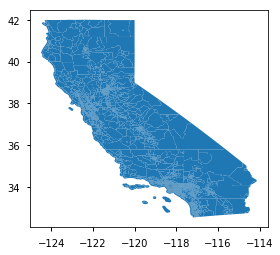

In [20]:
dfc.plot()

In [21]:
# The puma files moved, so the publicdata package is wrong. 
url = parse_app_url('shape+ftp://ftp2.census.gov/geo/tiger/TIGER2018/PUMA/tl_2018_06_puma10.zip')
pumas = url.get_resource().geoframe()

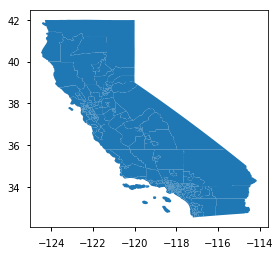

In [22]:
pumas.plot()

In [23]:
url = parse_app_url('census://2015/5/CA/county/B17001')
url.geo_url.shape_url

<FtpUrl shape+ftp://ftp2.census.gov/geo/tiger/TIGER2015/COUNTY/tl_2015_us_county.zip>

In [24]:
counties_pkg = mp.open_package('http://library.metatab.org/census.gov-counties-2017-2.csv')
counties = counties_pkg.resource('counties').geoframe()


In [25]:
sd = counties[counties.name == 'San Diego']

In [26]:
#import geopandas as gpd
#gpd.sjoin(pumas, sd)
